<a href="https://colab.research.google.com/github/pinakm9/sphere-fp/blob/master/notebooks/sphere2D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Import required modules**

In [1]:
# run this cell to download data and necessary modules
import os, shutil
repo = 'sphere-fp'
if os.path.isdir(repo):
  shutil.rmtree(repo)
!git clone https://github.com/pinakm9/sphere-fp.git
# add modules folder to Python's search path
import sys
sys.path.insert(0, repo + '/modules')
# import the necessary modules
import numpy as np
import tensorflow as tf
import lss_solver as lss
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

Cloning into 'sphere-fp'...
remote: Enumerating objects: 48, done.
remote: Counting objects: 100% (48/48), done.
remote: Compressing objects: 100% (31/31), done.
remote: Total 48 (delta 12), reused 46 (delta 10), pack-reused 0
Unpacking objects: 100% (48/48), done.


**Define the equation through the $\mathcal L_{\log}$ operator**

In [2]:
DTYPE = tf.float32
D = 1.0
dim = 2
ones = np.ones(dim)
domain = [-3. * ones, 3. * ones]
save_folder = '{}/data/2D'.format(repo)

@tf.function
def diff_log_op(f, x, y):
    z = 4.*(x**2 + y**2 - 1.)
    with tf.GradientTape(persistent=True) as tape:
        tape.watch([x, y])
        f_ = f(x, y)
        f_x, f_y = tape.gradient(f_, [x, y])
    f_xx = tape.gradient(f_x, x)
    f_yy = tape.gradient(f_y, y)
    return z*(x*f_x + y*f_y) + 4.*(z+2.) + D*(f_x**2 + f_y**2 + f_xx + f_yy) 

**Define the steady state $p_\infty(\mathbf x)$**

In [3]:
from scipy.special import erf
import numpy as np

def p_inf(x, y):
  Z = 0.5 * np.sqrt(np.pi**3 * D) * (1. + erf(1/np.sqrt(D)))
  return tf.exp(-(x**2 + y**2 - 1.)**2 / D) / Z

**Set up experiment parameters and learn the stationary distribution**

In [4]:
learning_rate = tf.keras.optimizers.schedules.PiecewiseConstantDecay([1000, 2000, 10000], [5e-3, 1e-3, 5e-4, 1e-4])
optimizer = tf.keras.optimizers.Adam(learning_rate)
solver = lss.LogSteadyStateSolver(num_nodes=50, num_blocks=3, dtype=DTYPE, name='sphere{}D'.format(dim), diff_log_op=diff_log_op, optimizer=optimizer, domain=domain)
solver.learn(epochs = 50000, n_sample = 1000, save_folder=save_folder)

Streaming output truncated to the last 5000 lines.
     012139.530273            8.1155
    10 1007.045044            8.4575
    20  291.455139            8.8434
    30  121.928436            9.1068
    40   67.079346            9.4147
    50   53.409695            9.7159
    60   43.743931           10.0458
    70   39.724125           10.2986
    80   35.390026           10.6332
    90   33.227585           10.9651
   100   31.071880           11.2996
   110   26.213346           11.6325
   120   27.873632           11.9879
   130   23.179308           12.3399
   140   21.703415           12.6438
   150   19.768267           13.0616
   160   19.001509           13.3778
   170   17.376564           13.7907
   180   18.219139           14.1269
   190   16.933912           14.3904
   200   17.885569           14.7151
   210   15.553590           14.9659
   220   15.901381           15.1229
   230   15.590267           15.2832
   240   15.462021           15.4428
   250   15.425902      

**Visualize the learned distribution**

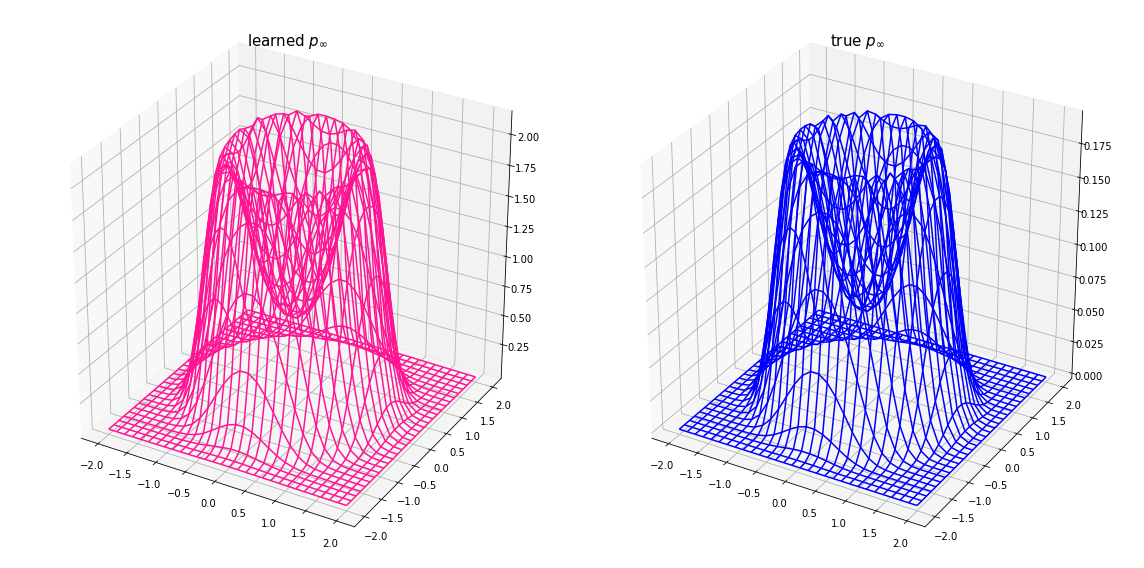

In [5]:
import matplotlib.pyplot as plt

def plot_solutions(learned, true, resolution=30, low=[-2., -2], high=[2., 2.]):
  fig = plt.figure(figsize=(16, 8))
  ax_l = fig.add_subplot(121, projection='3d')
  ax_t = fig.add_subplot(122, projection='3d')
  x = np.linspace(low[0], high[0], num=resolution, endpoint=True)
  y = np.linspace(low[1], high[1], num=resolution, endpoint=True)
  y = np.repeat(y, resolution, axis=0).reshape((-1, 1))
  x = np.array(list(x) * resolution).reshape((-1, 1))
  z_l = learned(x, y).numpy()
  z_t = true(x, y).numpy()
  grid = (resolution, resolution)
  x = x.reshape(grid)
  y = y.reshape(grid)
  z_l = z_l.reshape(grid)
  z_t = z_t.reshape(grid)
  ax_l.plot_wireframe(x, y, z_l, color='deeppink')
  ax_l.set_title('learned $p_\infty$', fontsize=15)
  ax_t.plot_wireframe(x, y, z_t, color='blue')
  ax_t.set_title('true $p_\infty$', fontsize=15)
  plt.tight_layout()
  plt.show()
  

plot_solutions(learned=lambda *args: tf.exp(solver.net(*args)), true=p_inf)

**Visulaize the noramlized learned solution**

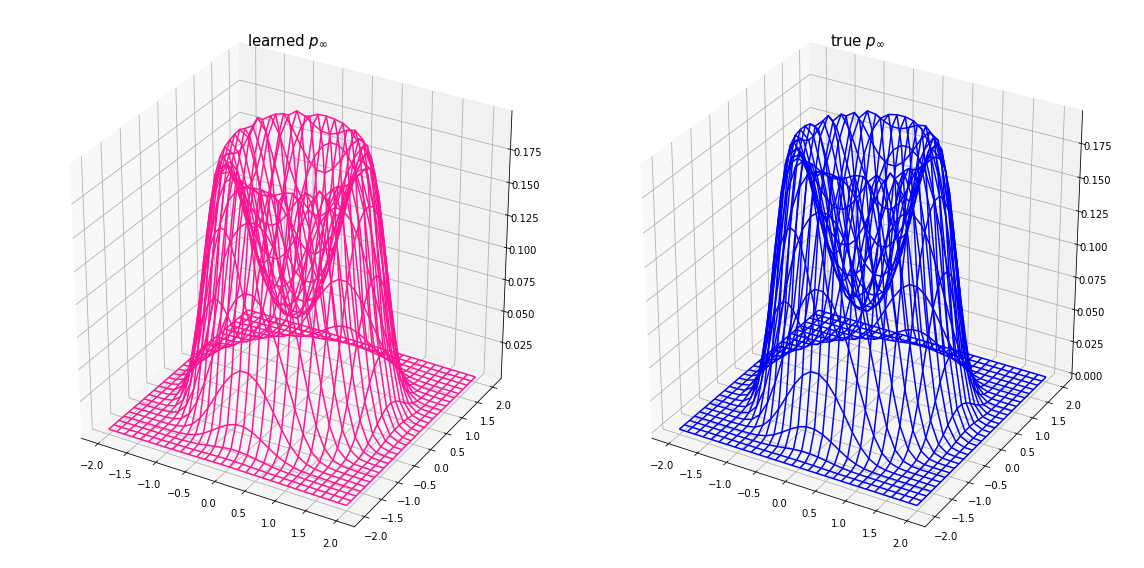

In [9]:
x, y = solver.sampler(n_sample=100000, domain=[-3. * ones, 3. * ones])
Z_mc = 6**2 * tf.reduce_mean(tf.exp(solver.net(x, y))).numpy()
plot_solutions(learned=lambda *args: tf.exp(solver.net(*args)) / Z_mc, true=p_inf)

**Investigate the size of $θ$**

In [10]:
solver.net.summary()

Model: "sphere2D"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 LSTMForgetBlock (LSTMForget  multiple                 1000      
 Block)                                                          
                                                                 
 LSTMForgetBlock (LSTMForget  multiple                 10600     
 Block)                                                          
                                                                 
 LSTMForgetBlock (LSTMForget  multiple                 10600     
 Block)                                                          
                                                                 
 dense (Dense)               multiple                  51        
                                                                 
 batch_normalization (BatchN  multiple                 0 (unused)
 ormalization)                                            